# Fairness: Bias Detection and Mitigation


Linking the US census data with the Lending Club loan data to assign racial proportions to zip codes, we can utilize IBMAIF360, The AI Fairness 360 toolkit, which is an open-source library to help detect and remove bias in machine learning models. We specifically look at how Caucasians fair on average, compared to other racial groups in terms of loan outcomes (fully paid or charged off). It is worth noting that we are not able to directly compare Caucasion borrowers with minority borrowers because we do not have the information on borrower's race. Instead, we use the 3-digit zip-code provided in the loan data to determine whether or not the borrower comes from an area with relatively large portions of minorities by population. We have assigned these borrowers to the "underprivileged" group.



After discovering a disparity between underprivileged and privileged groups in the outcomes, we can then reweigh the data in order to eliminate the inherent bias before feeding it into our models. 


In [0]:
import requests
#from IPython.core.display import HTML
#styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
#HTML(styles)

from IPython.display import clear_output
from datetime import datetime

%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5)
sns.set_style('ticks')

from os import listdir
from os.path import isfile, join


from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

import os

#Google Collab Only"
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

#os.listdir('/content/gdrive/My Drive/Lending Club Project/data')


In [0]:
#!pip install aif360
import sys
sys.path.append("../")  

from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import DatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.datasets import StandardDataset
from aif360.datasets import BinaryLabelDataset

from aif360.algorithms.preprocessing.optim_preproc import OptimPreproc
from aif360.algorithms.preprocessing.reweighing import Reweighing
from IPython.display import Markdown, display

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score
from sklearn.ensemble import RandomForestClassifier



---



**Combining the cleaned up with the US census data by linking the zip_code column.**




In [0]:
#loan_df= pd.read_pickle('clean_df.pkl')
path = '/content/gdrive/My Drive/Lending Club Project/data/Pickle/'
filename = 'clean_df_Mon.pkl'
loan_df= pd.read_pickle(path+filename)

In [0]:
path = '/content/gdrive/My Drive/Lending Club Project/data/census/'
filename = 'census_zipcode_level.csv'
print(os.listdir(path))

census_data= pd.read_csv(path+filename)

# read in census data
#census_data = pd.read_csv('census_zipcode_level.csv')

# generate 3-digit zip
census_data['zip_code_3dig'] = census_data['Zip'].apply(lambda x: (str(x))[:3])

#new df aggregated based on 3-digit zip code
zip3_df = census_data.groupby('zip_code_3dig').agg({'Population':np.sum, 'White':np.sum})
zip3_df['percent_white'] = zip3_df['White']/zip3_df['Population']
display(zip3_df.head())

# underprivileged group will be those 3-digit zipcodes in the bottom-quarter of "percent_white"
cutoff = zip3_df.percent_white.quantile(0.05) # about ## white
zip3_df['underprivileged'] = zip3_df.percent_white.apply(lambda x: x<=cutoff).astype(int)
underprivileged_zips = np.array(zip3_df[zip3_df.underprivileged==1].index)

['.DS_Store', 'census_zipcode_level.csv']


,Population,White,percent_white
zip_code_3dig,,,
100,1626010,778151,0.478565
101,92971,66973,0.720364
102,84350,68024,0.806449
103,510347,330622,0.647838
104,1479033,155696,0.105269


Assigning the underprivileged class as 1 and the privileged as 0 allows us to perform a two-class classification that places members of the cacusian race as privileged and members of other racial groups as 1. This allow us to perform a two class classification on one *sensitive* attribute.

This is a pre-processing step to mitigate any inherent bias that may be present in our dataset and mitigating it, before feeding it into our classifier.

In [0]:
loan_df['underprivileged'] = loan_df.zip_code.apply(lambda x: x in (underprivileged_zips)).astype(int)
loan_df.underprivileged.value_counts() #underprivileged = 1

0    960120
1    127316
Name: underprivileged, dtype: int64

In [0]:
outcome_column='fully_paid'
data_train, data_test = train_test_split(loan_df, test_size = 0.1, shuffle = True, stratify = loan_df[outcome_column], random_state =99)
print(data_train.shape, data_test.shape)
X_train = data_train.drop(columns=[outcome_column,'credit_line_age','issue_d','addr_state','zip_code'])
y_train = data_train[outcome_column]

X_test = data_test.drop(columns=[outcome_column,'credit_line_age','issue_d','addr_state','zip_code'])
y_test = data_test[outcome_column]


data_train, data_val = train_test_split(data_train, test_size=.2, stratify=data_train[outcome_column], random_state=99)
print(data_train.shape, data_val.shape)

(978692, 88) (108744, 88)
(782953, 88) (195739, 88)


In [0]:
importances = ['int_rate', 'sub_grade', 'dti', 'installment', 'avg_cur_bal', 'mo_sin_old_rev_tl_op', 'bc_open_to_buy', 'credit_line_age', 'tot_hi_cred_lim', 'annual_inc', 'revol_util', 'bc_util', 'mo_sin_old_il_acct', 'revol_bal', 'total_rev_hi_lim', 'total_bc_limit', 'tot_cur_bal', 'total_bal_ex_mort', 'loan_amnt', 'total_il_high_credit_limit', 'mths_since_recent_bc', 'total_acc', 'mo_sin_rcnt_rev_tl_op', 'num_rev_accts', 'num_il_tl', 'grade', 'mths_since_recent_inq', 'mo_sin_rcnt_tl', 'num_bc_tl', 'acc_open_past_24mths', 'open_acc', 'num_sats', 'pct_tl_nvr_dlq', 'num_op_rev_tl', 'mths_since_last_delinq', 'percent_bc_gt_75', 'term_ 60 months', 'num_actv_rev_tl', 'num_rev_tl_bal_gt_0', 'num_bc_sats', 'num_actv_bc_tl', 'num_tl_op_past_12m', 'mths_since_recent_revol_delinq', 'mort_acc', 'mths_since_last_major_derog', 'mths_since_recent_bc_dlq', 'tot_coll_amt', 'mths_since_last_record', 'inq_last_6mths', 'num_accts_ever_120_pd', 'delinq_2yrs', 'pub_rec', 'verification_status_Verified', 'verification_status_Source Verified', 'emp_length_10+ years', 'purpose_debt_consolidation', 'emp_length_5-9 years', 'emp_length_2-4 years', 'home_ownership_RENT', 'purpose_credit_card', 'pub_rec_bankruptcies', 'home_ownership_MORTGAGE', 'home_ownership_OWN', 'num_tl_90g_dpd_24m', 'tax_liens', 'purpose_other', 'purpose_home_improvement', 'collections_12_mths_ex_med', 'purpose_major_purchase', 'purpose_small_business', 'purpose_medical', 'application_type_Joint App', 'purpose_moving', 'chargeoff_within_12_mths', 'purpose_vacation', 'delinq_amnt', 'purpose_house', 'acc_now_delinq', 'purpose_renewable_energy', 'purpose_wedding', 'home_ownership_OTHER', 'home_ownership_NONE', 'purpose_educational']

Using a Logistic Regression model  with balanced class weight to use the values of y to automatically adjust weights inversely proportional to class frequencies in the input data. And then fitting it onto X_train and y_train. 

In [0]:
lrm = LogisticRegression(class_weight='balanced').fit(X_train, y_train)

** A wraper function to create aif360 dataset from outcome and protected in numpy array format.**





In [0]:
def dataset_wrapper(outcome, protected, unprivileged_groups, privileged_groups,
                          favorable_label, unfavorable_label):
    
    df = pd.DataFrame(data=outcome,
                      columns=[outcome_column])
    df['underprivileged'] = protected
    
    dataset = BinaryLabelDataset(favorable_label=favorable_label,
                                       unfavorable_label=unfavorable_label,
                                       df=df,
                                       label_names=[outcome_column],
                                       protected_attribute_names=['underprivileged'],
                                       unprivileged_protected_attributes=unprivileged_groups)
    return dataset

In [0]:
u = [{'underprivileged': 1.0}]
p = [{'underprivileged': 0.0}]
favorable_label = 1.0 
unfavorable_label = 0.0
protected_train = data_train['underprivileged'] 
protected_test = data_test['underprivileged']

**We create a new dataset from the prediction on X_test. This way everything except the labels is copied from the ground-truth test set.**

In [0]:
y_pred2=pd.DataFrame(y_test)
y_pred2['predictions']=lrm.predict(X_test)
y_pred2=y_pred2.drop([outcome_column], axis=1).rename(columns={'predictions': outcome_column})

In [0]:
#y_train
original_training_dataset = dataset_wrapper(outcome=y_train, protected=protected_train, 
                                                 unprivileged_groups=u, 
                                                 privileged_groups=p,
                                                 favorable_label=favorable_label,
                                          unfavorable_label=unfavorable_label)
#y_test
original_test_dataset = dataset_wrapper(outcome=y_test, protected=protected_test, 
                                              unprivileged_groups=u, 
                                              privileged_groups=p,
                                                 favorable_label=favorable_label,
                                          unfavorable_label=unfavorable_label)

#test_predictions
plain_predictions_test_dataset = dataset_wrapper(outcome=y_pred2, protected=protected_test, 
                                                       unprivileged_groups=u,
                                                       privileged_groups=p,
                                                 favorable_label=favorable_label,
                                          unfavorable_label=unfavorable_label)

**Fairness: Test vs Predictions**

In [0]:
classified_metric_nodebiasing_test = ClassificationMetric(original_test_dataset, 
                                                 plain_predictions_test_dataset,
                                                 unprivileged_groups=u,
                                                 privileged_groups=p)

display(Markdown("#### Plain model - without debiasing - classification metrics"))
print("Test set: Classification accuracy = %f" % classified_metric_nodebiasing_test.accuracy())
#print("Test set: Balanced classification accuracy = %f" % bal_acc_nodebiasing_test)
print("Test set: Statistical parity difference = %f" % classified_metric_nodebiasing_test.statistical_parity_difference())
print("Test set: Disparate impact = %f" % classified_metric_nodebiasing_test.disparate_impact())
print("Test set: Equal opportunity difference = %f" % classified_metric_nodebiasing_test.equal_opportunity_difference())
print("Test set: Average odds difference = %f" % classified_metric_nodebiasing_test.average_odds_difference())
print("Test set: Theil index = %f" % classified_metric_nodebiasing_test.theil_index())
print("Test set: False negative rate difference = %f" % classified_metric_nodebiasing_test.false_negative_rate_difference())

#### Plain model - without debiasing - classification metrics

Test set: Classification accuracy = 0.652441
Test set: Statistical parity difference = -0.019635
Test set: Disparate impact = 0.966937
Test set: Equal opportunity difference = -0.013784
Test set: Average odds difference = -0.013502
Test set: Theil index = 0.354349
Test set: False negative rate difference = 0.013784


**Reweigh via tranformation for Training**

In [0]:
RW = Reweighing(unprivileged_groups=u,
               privileged_groups=p)
RW.fit(original_training_dataset)
transf_training_dataset = RW.transform(original_training_dataset)

In [0]:
metric_orig_train = BinaryLabelDatasetMetric(original_training_dataset, 
                                             unprivileged_groups=u,
                                             privileged_groups=p)
metric_tranf_train = BinaryLabelDatasetMetric(transf_training_dataset, 
                                             unprivileged_groups=u,
                                             privileged_groups=p)

display(("Original training dataset"))
print("Difference in mean outcomes between privileged and unprivileged groups = %f" % metric_orig_train.mean_difference())
display(("Transformed training dataset"))
print("Difference in mean outcomes between privileged and unprivileged groups = %f" % metric_tranf_train.mean_difference())

'Original training dataset'

Difference in mean outcomes between privileged and unprivileged groups = -0.017565


'Transformed training dataset'

Difference in mean outcomes between privileged and unprivileged groups = 0.000000


**Reweight via transformation for test**

In [0]:
metric_orig_test = BinaryLabelDatasetMetric(original_test_dataset, 
                                             unprivileged_groups=u,
                                             privileged_groups=p)
transf_test_dataset = RW.transform(original_test_dataset)
metric_transf_test = BinaryLabelDatasetMetric(transf_test_dataset, 
                                             unprivileged_groups=u,
                                             privileged_groups=p)
display(("Original testing dataset"))
print("Difference in mean outcomes between privileged and unprivileged groups = %f" % metric_orig_test.mean_difference())
display(("Transformed testing dataset"))
print("Difference in mean outcomes between privileged and unprivileged groups = %f" % metric_transf_test.mean_difference())

'Original testing dataset'

Difference in mean outcomes between privileged and unprivileged groups = -0.019698


'Transformed testing dataset'

Difference in mean outcomes between privileged and unprivileged groups = -0.002036




---



**Using the instance weights from the transformed training dataset we fit our final model, a Random Forest Classifier.**





In [0]:
features = importances[0:43]
depth = 8
weight = 6
    
rf_model = RandomForestClassifier(n_estimators=500, max_depth=depth, class_weight={0:weight, 1:1})

In [0]:
rf_model.fit(X_train, y_train, sample_weight = transf_training_dataset.instance_weights)

RandomForestClassifier(bootstrap=True, class_weight={0: 6, 1: 1},
            criterion='gini', max_depth=8, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [0]:
y_pred_test = rf_model.predict(X_test)
precision_score(y_test, y_pred_test)

0.9132855609098399

In [0]:
rf_model.score(X_test, y_test)

0.5066946222320312

In [0]:
data_test['RF_Model_Prediction'] = rf_model.predict(X_test) 
data_test['RF_Probability_Fully_Paid'] = rf_model.predict_proba(X_test)[:,1]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


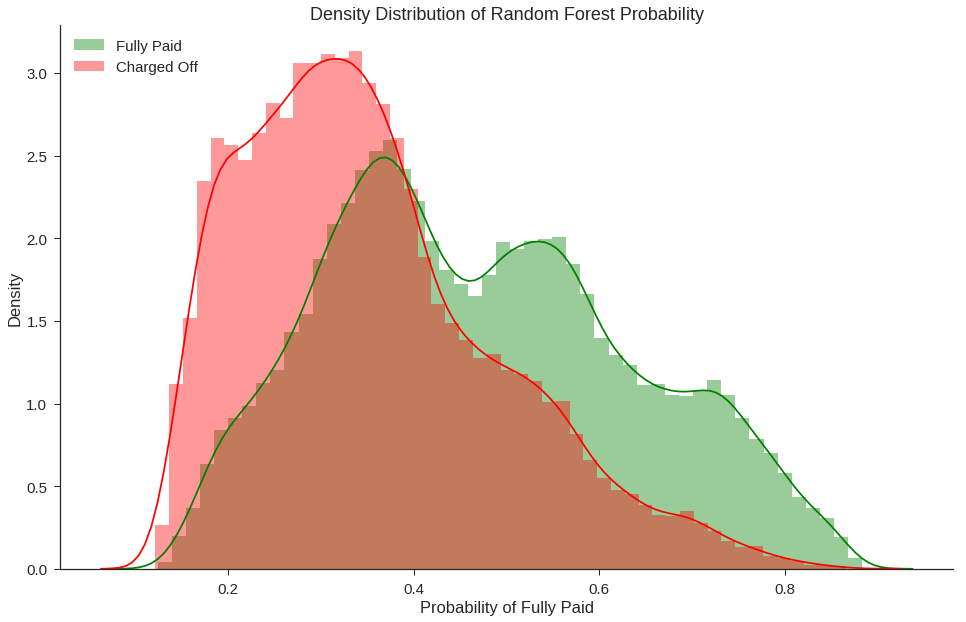

In [0]:
fig, ax = plt.subplots(figsize=(16,10))

sns.distplot(data_test[data_test['fully_paid']==1]['RF_Probability_Fully_Paid'],color='green',rug=False,label='Fully Paid')
sns.distplot(data_test[data_test['fully_paid']==0]['RF_Probability_Fully_Paid'],color='red',rug=False,label='Charged Off')

ax.set_title('Density Distribution of Random Forest Probability')
ax.set_xlabel('Probability of Fully Paid')
ax.set_ylabel('Density')
plt.legend(loc='upper left')

sns.despine()

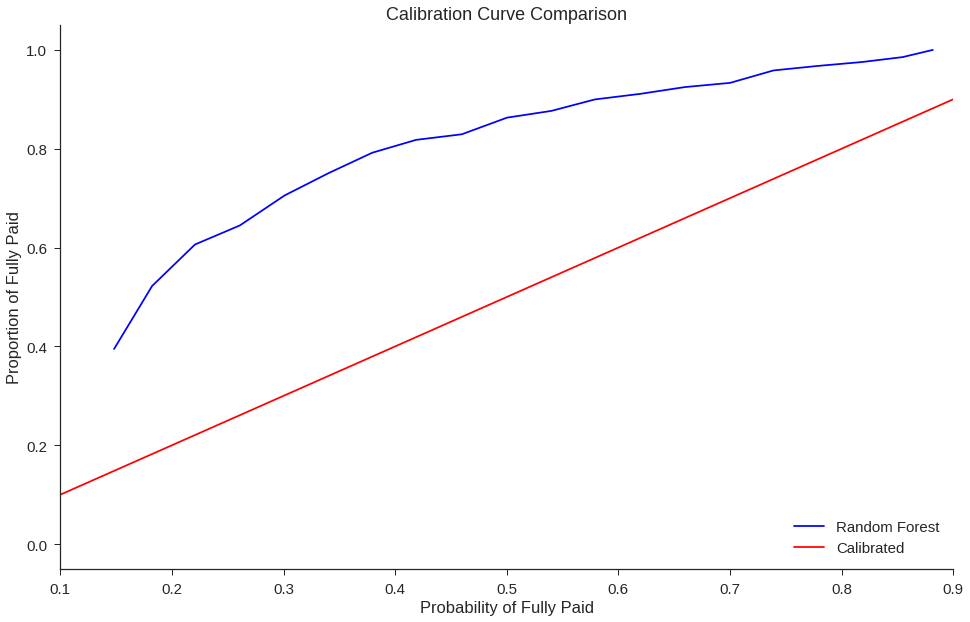

In [0]:
from sklearn.calibration import calibration_curve

rf_positive_frac, rf_mean_score = calibration_curve(y_test, data_test['RF_Probability_Fully_Paid'].values, n_bins=25)
#tree_positive_frac, tree_mean_score = calibration_curve(y_test, data_test['Tree_Probability_Fully_Paid'].values, n_bins=25)

fig, ax = plt.subplots(figsize=(16,10))

ax = plt.plot(rf_mean_score,rf_positive_frac, color='b', label='Random Forest')
#ax = sns.lineplot(tree_mean_score,tree_positive_frac, color='blue', label='Decision Tree')
ax = plt.plot([0, 1], [0, 1], color='r', label='Calibrated')

plt.title('Calibration Curve Comparison')
plt.xlabel('Probability of Fully Paid')
plt.ylabel('Proportion of Fully Paid')
plt.xlim(.1, .9)
plt.legend(loc='lower right')

sns.despine()